In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path_to_data = "../raw/trabajo6.csv"

In [30]:
df = pd.read_csv(path_to_data)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Análisis de los datos y las variables que tenemos

Observamos que no hay NAs:

In [4]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Boxplot de las cantidades que se manejan según el 'Type' de operación:

<AxesSubplot:xlabel='amount', ylabel='type'>

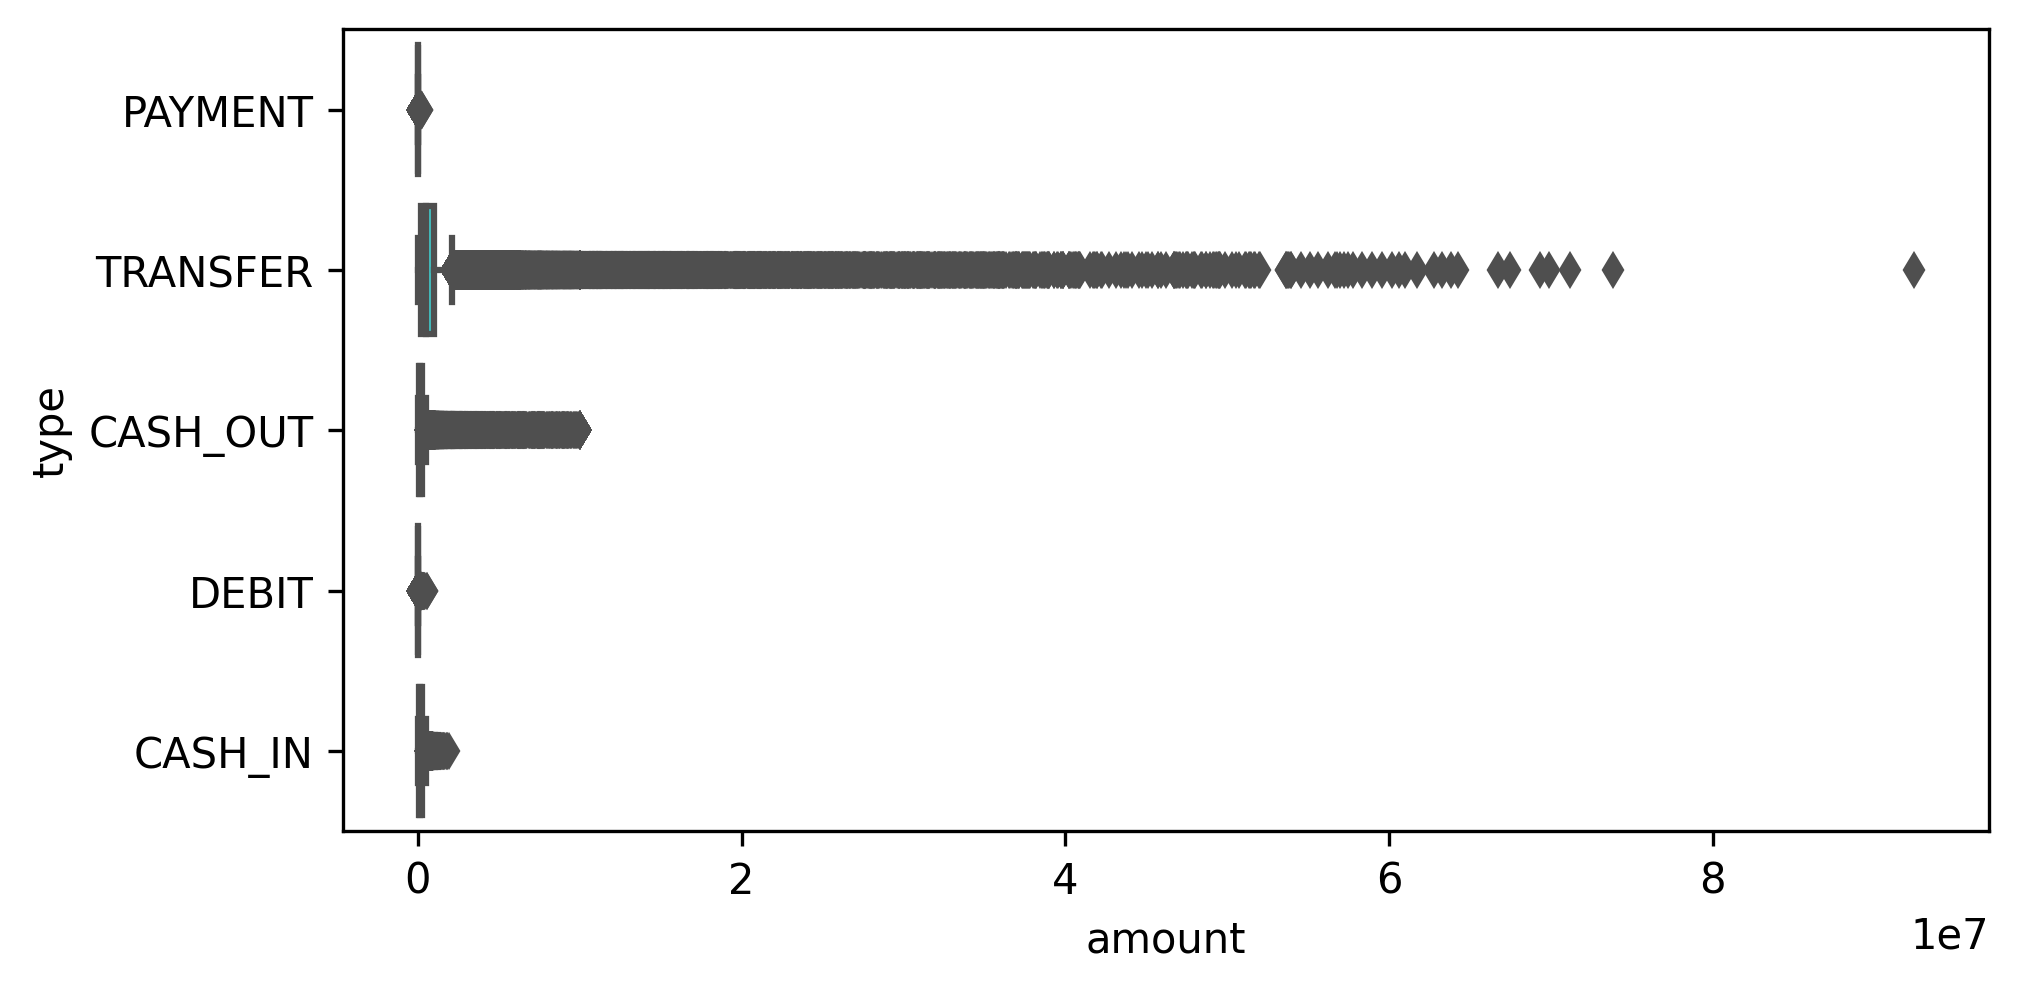

In [12]:
fig, ax = plt.subplots(figsize=(7.08,3.54), dpi=300)

sns.boxplot(x="amount", y="type", data=df,
            #whis=[0, 100], width=.6, 
            palette="rainbow")

### Existe un gran número de outliers, tanto en las operaciones de 'CASH' como en la de tipo 'TRANSFER'. Deberemos analizar esto en mayor profundidad más adelante.

### Vamos a hacer el plot anterior más legible con una escala logarítmica:

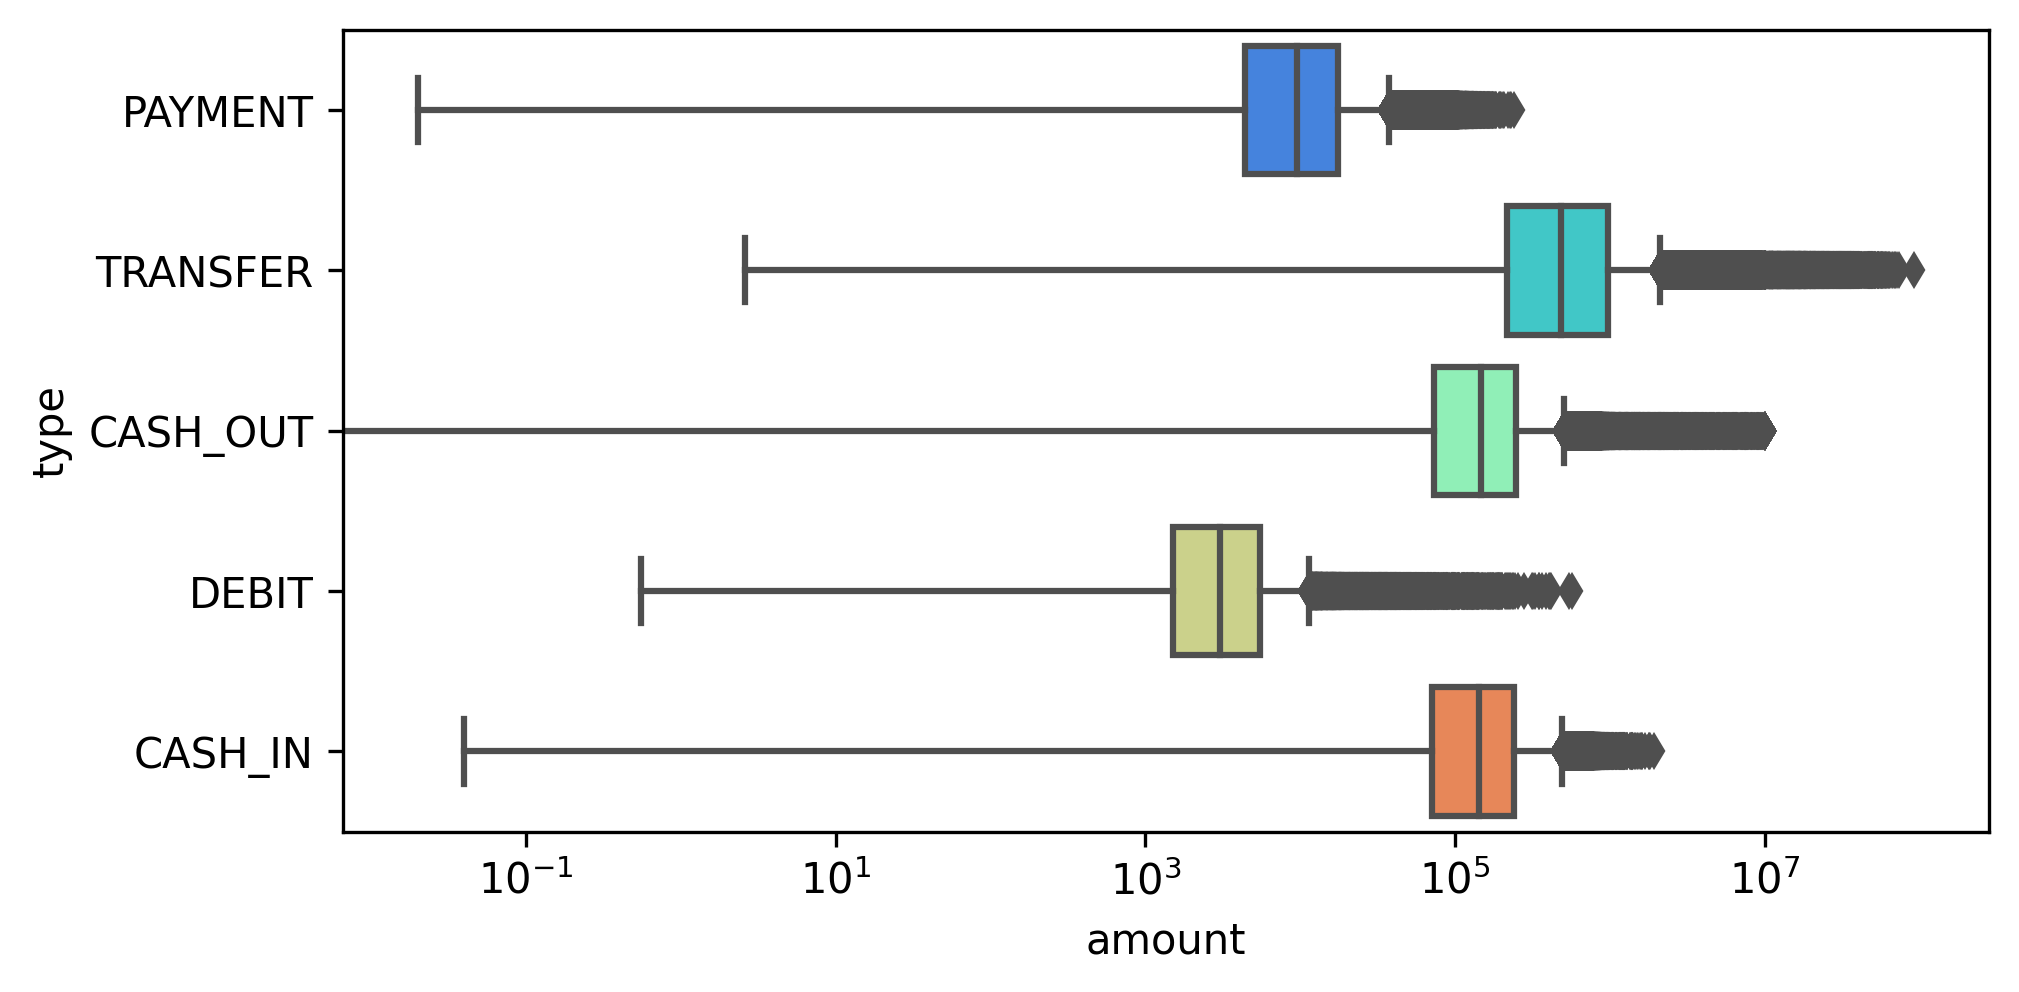

In [13]:
fig, ax = plt.subplots(figsize=(7.08,3.54), dpi=300)

sns.boxplot(x="amount", y="type", data=df,
            #whis=[0, 100], width=.6, 
            palette="rainbow")

plt.xscale('log')

plt.show()

### Las distribuciones son completamente dispares entre operaciones de Payment y Debit que son mucho más reducidas, pero aun así **también cuentan con un número muy elevado de outliers**.

### Proporciones de fraude dentro de cada tipo de transacción:

In [8]:
groupby_type  = df.groupby('type')

registros_sum = pd.DataFrame(groupby_type.count()['isFraud'])
fraudes_sum   = pd.DataFrame(groupby_type.sum()['isFraud'])

df_porcentajes = registros_sum.join(fraudes_sum, how='left', lsuffix='_registros', rsuffix='_count')

df_porcentajes['porcentaje'] = (df_porcentajes.isFraud_count/df_porcentajes.isFraud_registros)

df_porcentajes

,isFraud_registros,isFraud_count,porcentaje
type,,,
CASH_IN,1399284,0,0.000000
CASH_OUT,2237500,4116,0.001840
DEBIT,41432,0,0.000000
PAYMENT,2151495,0,0.000000
TRANSFER,532909,4097,0.007688


Plot con resultados:

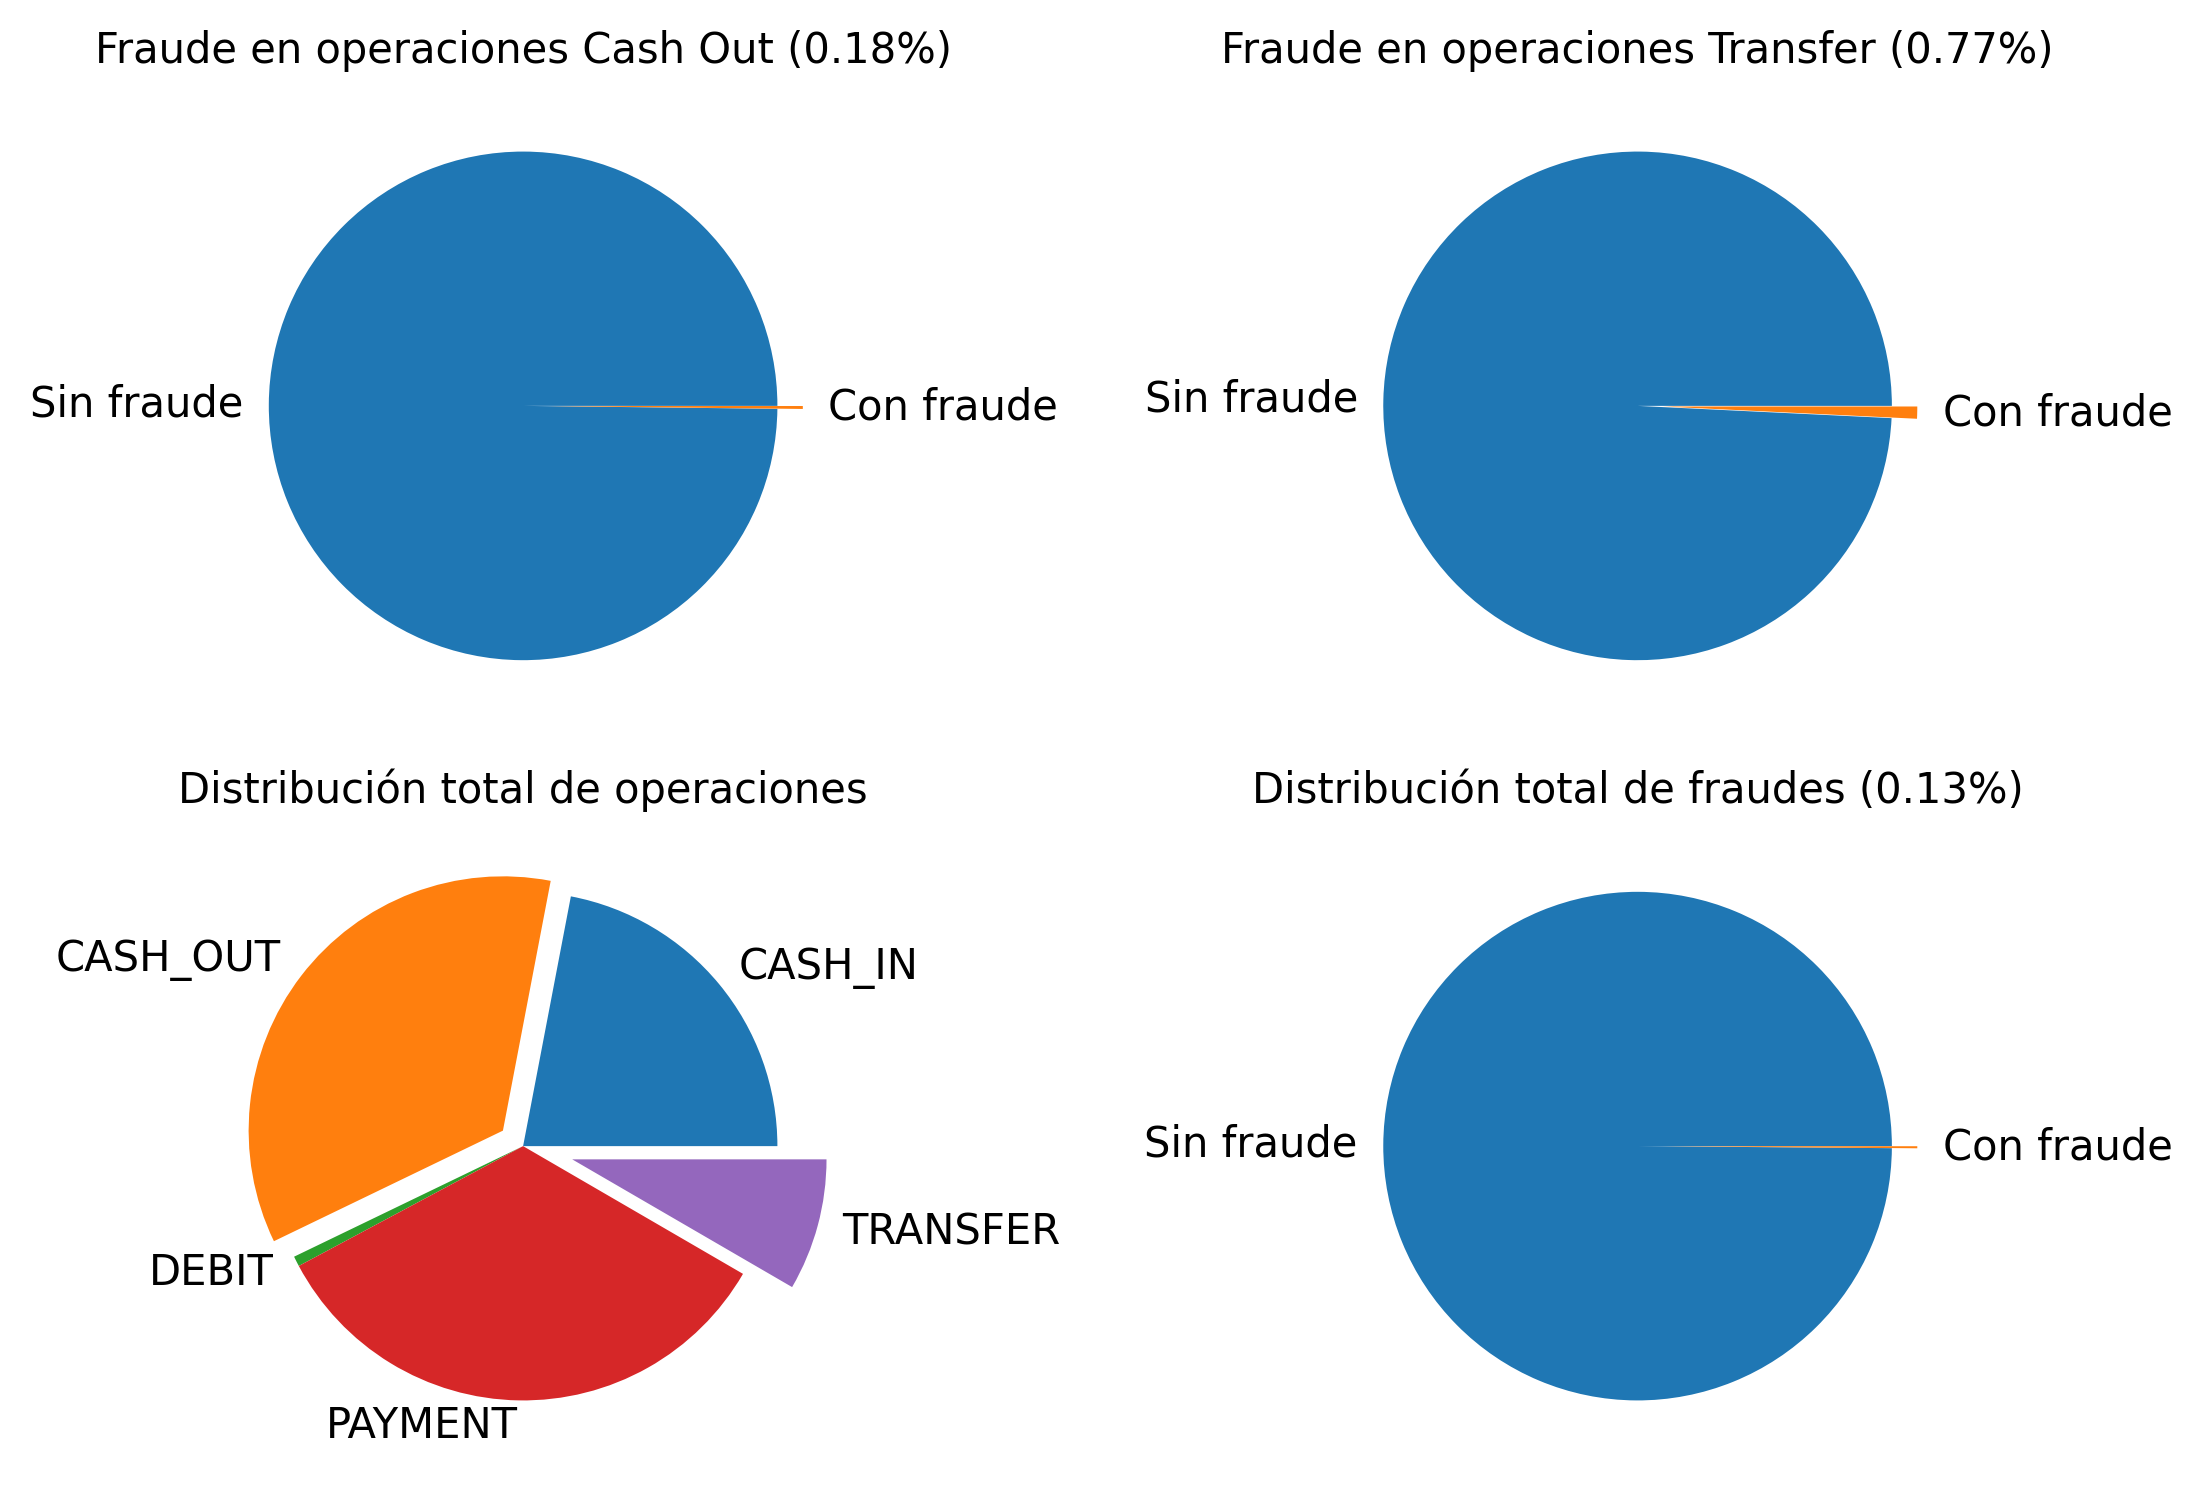

In [9]:
fig, ax = plt.subplots(figsize=(7.58,5.08), dpi=300, ncols=2, nrows=2)

axes = ax.flatten()

# -------- PLOT 1 -----------
fr = 0.001840*100
labels = ['Sin fraude', 'Con fraude']
data   = [100-fr,fr]

axes[0].pie(data, labels = labels, 
        #colors = colors,
        explode=[0,.1], autopct='')

axes[0].set_title('Fraude en operaciones Cash Out (' + str(round(100*data[1]/data[0],2)) + '%)', fontsize=10)

# -------- PLOT 2 -----------
fr = 0.007688*100
labels = ['Sin fraude', 'Con fraude']
data   = [100-fr,fr]

axes[1].pie(data, labels = labels, 
        #colors = colors,
        explode=[0,.1], autopct='')

axes[1].set_title('Fraude en operaciones Transfer (' + str(round(100*data[1]/data[0],2)) + '%)', fontsize=10)

# -------- PLOT 3 -----------
labels = df_porcentajes.index
data   = df_porcentajes['isFraud_registros']

axes[2].pie(data, labels = labels, 
        #colors = colors,
        explode=[0,.1,0,0,.2], autopct='')

axes[2].set_title('Distribución total de operaciones', fontsize=10)

# -------- PLOT 4 -----------
labels = ['Sin fraude', 'Con fraude']
data   = [df_porcentajes.isFraud_registros.sum(), df_porcentajes.isFraud_count.sum()]

axes[3].pie(data, labels = labels, 
        #colors = colors,
        explode=[0,.1], autopct='')

axes[3].set_title('Distribución total de fraudes (' + str(round(100*data[1]/data[0],2)) + '%)', fontsize=10)

plt.tight_layout()

plt.show()



### De las gráficas anteriores concluimos claramente que el dataset se encuentra desbalanceado, con solo 8213 casos (0.13% del dataset). Habrá que remediar esto, con técnicas como SMOTE o asignando pesos más elevados al acierto de fraudes.

### Por otro lado, observamos también que solo se obtienen fraude en las transacciones de Transfer y Cash Out, por lo que la variable de Type es muy importante para detectar fraude. Esta variable se incluirá de manera numérica realizando un ***One Hot Encoding*** de la columna 'Type'.

In [31]:
# One Hot Encoding de la columna type:
df_n = df.join(pd.get_dummies(df['type']))

df_n.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,0,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,1,0


### Vamos a pintar los balances de origen y destino antes de cada transacción:

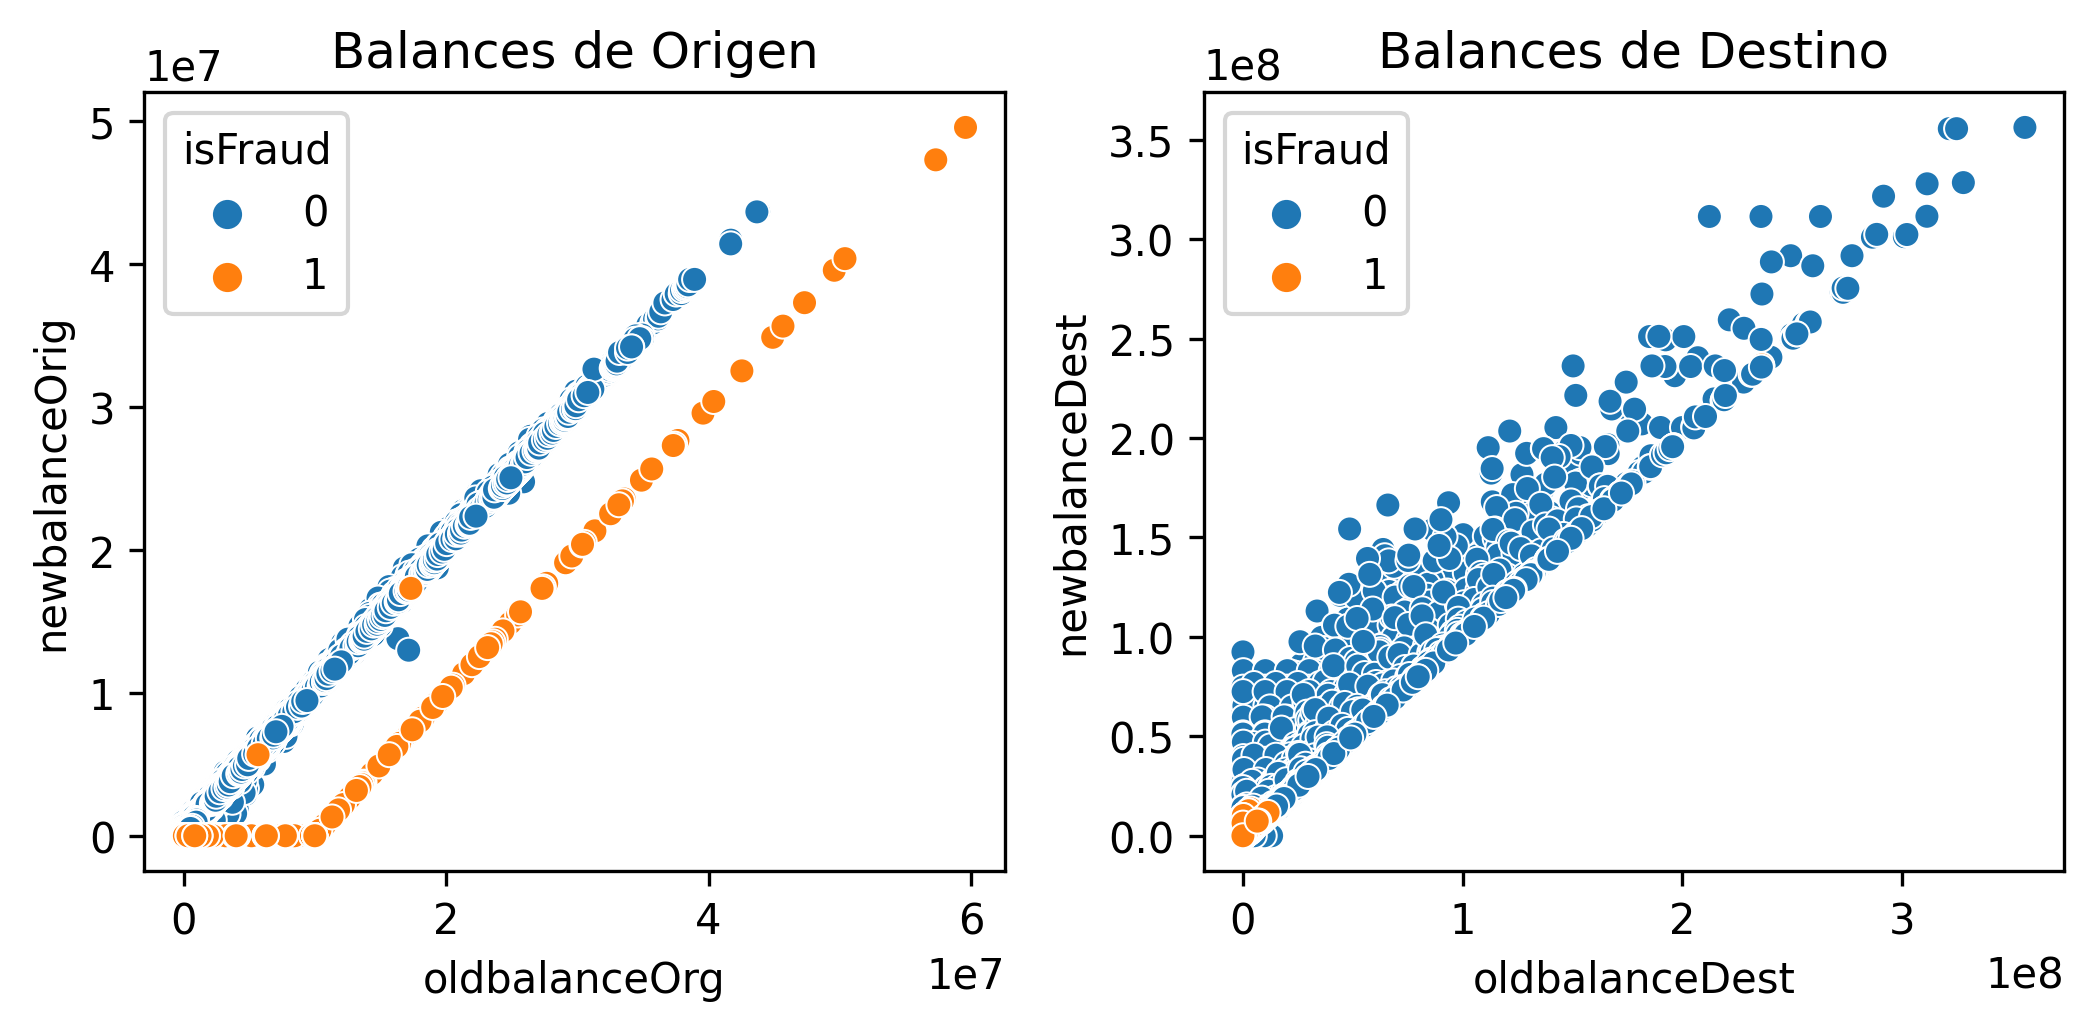

In [20]:
fig, axes = plt.subplots(figsize=(7.08,3.54), dpi=300, ncols=2)

sns.scatterplot(data=df, x='oldbalanceOrg', y='newbalanceOrig', hue='isFraud', ax=axes[0])
axes[0].set_title('Balances de Origen')

sns.scatterplot(data=df, x='oldbalanceDest', y='newbalanceDest', hue='isFraud', ax=axes[1])
axes[1].set_title('Balances de Destino')

fig.tight_layout()

plt.show()

### Se ve claramente la relación entre los cambios de balance en origen: Las operaciones fraudulentas sacan mucho más dinero de la cuenta de Origen. Además de eso, suelen dejar la cuenta de origen a cero con más frecuencia.

### Por otro lado, es interesante ver que la cuenta de destino recibe muy poco dinero antes y después de la operación, indicando posiblemente que los fondos no han ido a parar a la cuenta de destino.

## Gracias a este análsis vamos a añadirle al modelo las variables de resta entre balance antes y después de origen y destino, así como una variable de resta entre 'newbalanceDest' y 'amount'.

### Realizamos un PCA para ver si realmente se pueden diferenciar claramente cualidades distintas de las transacciones fraudulentas:

In [32]:
df_n['diffOrigen'] = df_n['newbalanceOrig'] - df_n['oldbalanceOrg']
df_n['diffDestino'] = df_n['newbalanceDest'] - df_n['oldbalanceDest']

### Indicamos también cambios porcentuales. Si una cuenta tenía 10€ y recibe 10.000 de golpe puede ayudar a saltar las alarmas.

In [33]:
df_n['cambioOrigen'] = df_n['diffOrigen']/(df_n['oldbalanceOrg']+0.1)
df_n['cambioDestino'] = df_n['diffDestino']/(df_n['oldbalanceDest']+0.1) # Para evitar NaN

In [34]:
df_n

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,diffOrigen,diffDestino,cambioOrigen,cambioDestino
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0,0,1,0,-9839.64,0.00,-0.057834,0.000000e+00
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0,0,1,0,-1864.28,0.00,-0.087735,0.000000e+00
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,0,1,-181.00,0.00,-0.999448,0.000000e+00
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,1,0,0,0,-181.00,-21182.00,-0.999448,-9.999953e-01
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0,0,1,0,-11668.14,0.00,-0.280794,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0,1,0,0,0,-339682.13,339682.13,-1.000000,3.396821e+06
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0,0,0,0,1,-6311409.28,0.00,-1.000000,0.000000e+00
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,0,1,0,0,0,-6311409.28,6311409.27,-1.000000,9.215224e+01
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0,0,0,0,1,-850002.52,0.00,-1.000000,0.000000e+00


## Descomposición de variables:

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [40]:
pipe = Pipeline(steps=[
    ('scaler',StandardScaler()),
    ('pca', PCA(n_components=2))
])

In [37]:
df_pipe = df_n.copy()
fraude_real = df_pipe.pop('isFraud')
fraude_flag = df_pipe.pop('isFlaggedFraud')
tipo = df_pipe.pop('type')
df_pipe.drop(columns=['nameOrig','nameDest'], inplace=True)

In [46]:
df_pca = pd.DataFrame(pipe.fit_transform(df_pipe),columns=['PC1','PC2'])
df_pca['isFraud'] = fraude_real
df_pca['isFlaggedFraud'] = fraude_flag

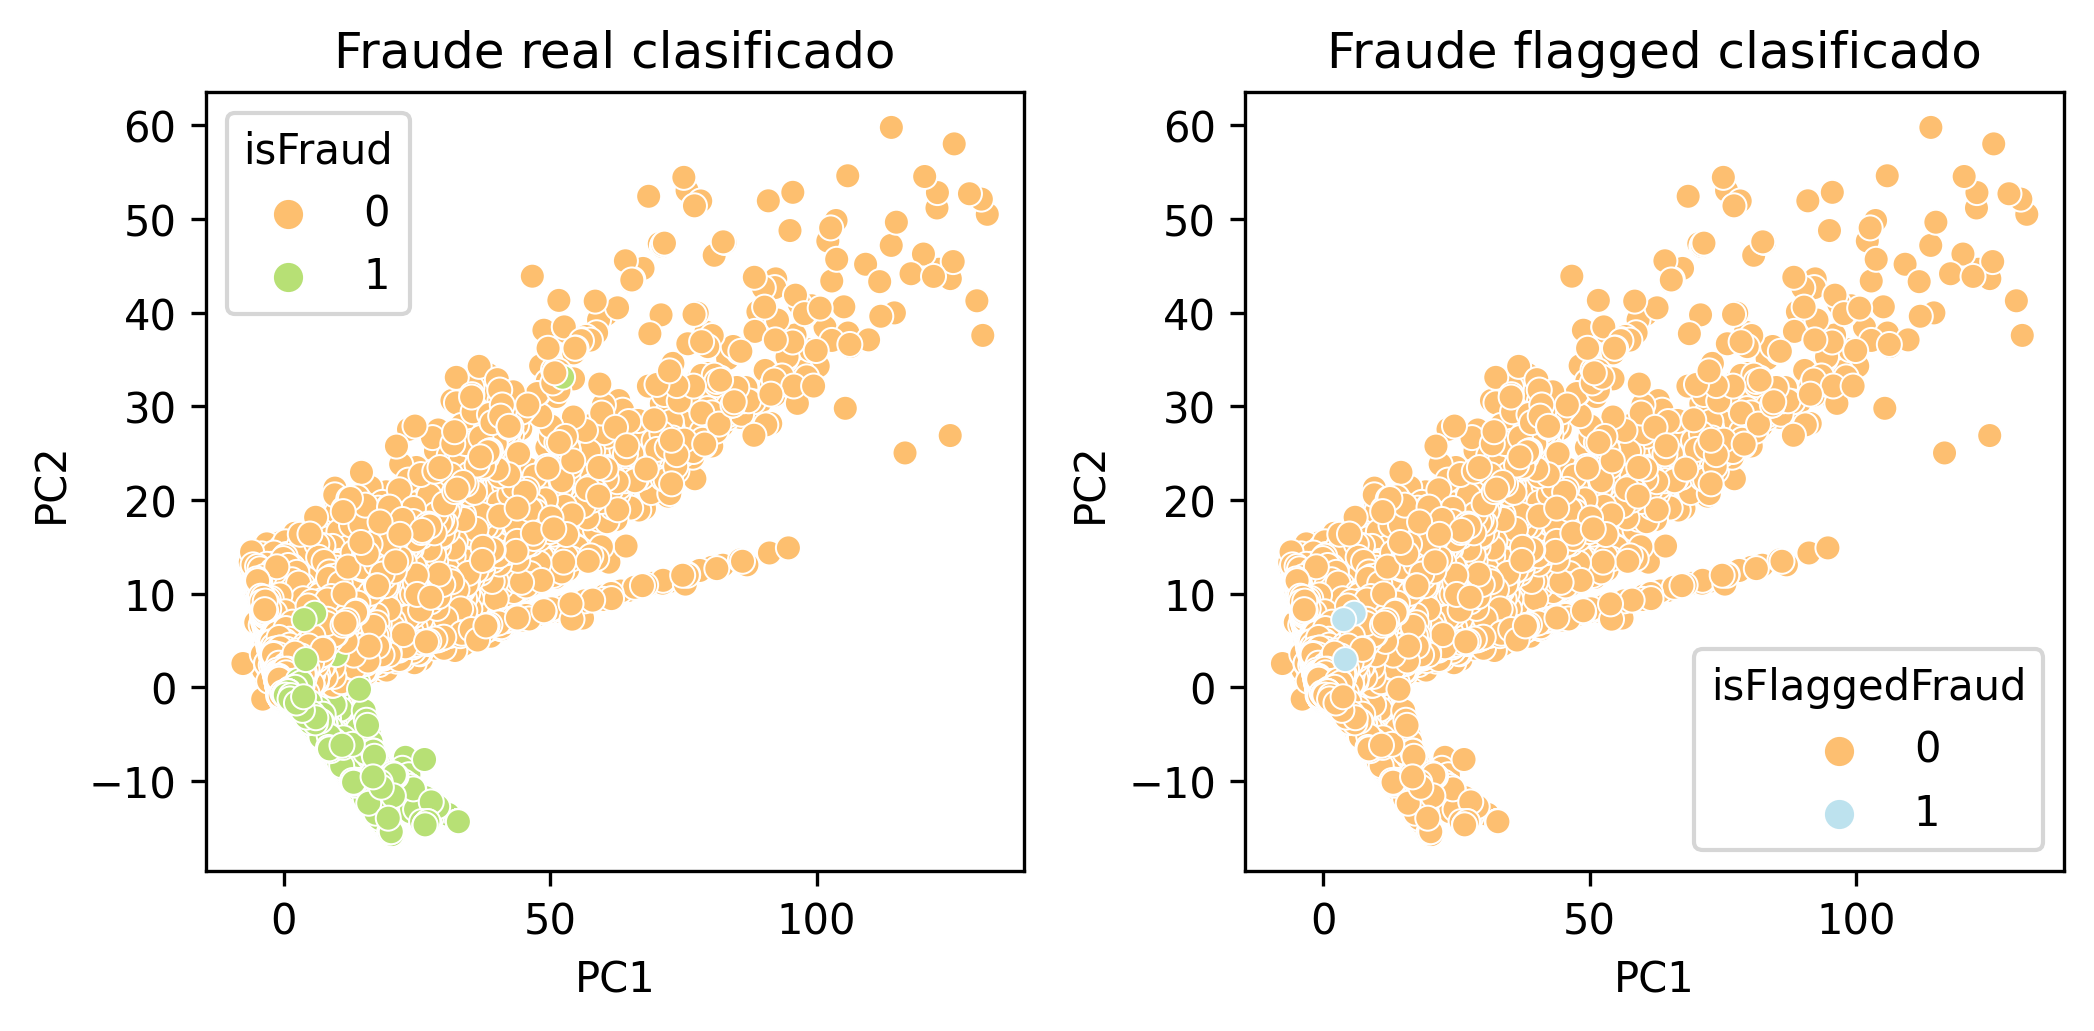

In [47]:
fig, axes = plt.subplots(figsize=(7.08,3.54), ncols=2, dpi=300)
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=fraude_real, palette='RdYlGn', ax=axes[0])
axes[0].set_title('Fraude real clasificado')
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=fraude_flag, palette='RdYlBu', ax=axes[1])
axes[1].set_title('Fraude flagged clasificado')

plt.tight_layout()
plt.show()